# CS6493 Natural Language Processing - Tutorial 9 Position Encoding

## Welcome to tutorial 9! In this tutorial, we will introduce position encoding in Transformer models, including absolute position encoding, relative position encoding, rotary position encoding. 

## 1. Why Position Encoding?

For classic sequence modeling models like CNN and RNN, they could fuse the local information, which is sensitive to the relative positions of tokens.


However, compared with the CNN and RNN models, the Self-Attention model is not sensitive to the positions of tokens due to its global context attention, which means that two sequences with the same tokens but different orders will obtain the same outputs from Self-Attention model.


Therefore, it is necessary to add the position information of tokens to thier final representations or distinguish the relative position between two elements when calculating attention scores. We could achieve above scores via Position Encoding.




## 2. The type of Position Encoding
### 2.1 Absolute Position Encoding
#### a) Learnable Position Encoding
Learnable absolute position encoding will assign each position a learnable embedding and add the embedding to the corresponding token representation. This method is proposed by ConvS2S.

However, this method have two main drawbacks:

(1) The training of position encoding relies on volumes of data.

(2) The relative information between position encodings is not fully utilized.

#### b) Fix Position Encoding
Another absolute position embedding is fixed absolute position encoding. A representative position is sinusoidal funcition position encoding.

In sinusoidal function position encoding, we could represent the position encoding of position $t$ as:

$PE_{(t, 2i)} = sin(\frac{t}{10000^{2i/d}})$

$PE_{(t, 2i+1)} = cos(\frac{t}{10000^{2i/d}})$

where $2i$ and $2i+1$ are even and odd bits in the position encoding.

### 2.2 Relative Position Encoding

Absolute position encoding is to embed the position encoding directly into the representation of the sequence, while relative position encoding refers to directly considering the relative position between two tokens when calculating the attention score, that is,

$S_{ij} = q_i k^\top_j + b_{ij} = x_i W_Q W^\top_K x^\top_j + b_{ij}$

where, $b_ij$ is position bias and we could divide relative position encoding into two classes:

1) bias mode

  T5: $b_ij = r_ij$, where $r_ij$ is the relative position vector.

  TUPE: $b_ij = p_i U_Q U_K p^\top_j$


2) contextual mode: $b_ij = f(x_i, x_j, r_{ij})$

  Transformer-XL: $b_ij = x_iW_QW_R^\top r^\top_{ij} + v W_R^\top r^\top_{ij} + u W_K^\top x^\top_j$

  DeBERTa: $b_{ij} = x_iW_QW_K^\top r^\top_{ij} + x_j W_K W_Q^\top r^\top_{ji}$

### 2.3 Relative Position Encoding + Piecewise Function

Considering a fact that when relative positions of two tokens are 101 and 102, their position encodings will be similar. Therefore, we could set a threshold such as 100. Distances greater than 100 will be mapped to 100, distances less than -100 will be mapped to -100. In this case, the whole parameter number will be reduced to $201 \times d$. A more advanced method is to use a piecewise function to map the relative positions like the following figure.

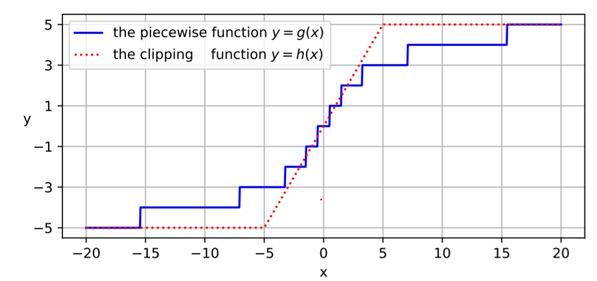

Absolute position coding has the advantages of simple implementation and fast calculation speed. And its shortcomings are also obvious, because what really matters is often not the absolute position, but the relative position between tokens.

Although the triangular position code, as an absolute position code, contains certain relative position information, this relative position information is only included in the position code. When adding position-encoded representations to calculate self-attention, it is unknown whether the relative position information in the representations is still preserved.

In addition, for linear attention, relative position encoding cannot be directly applied. Therefore, it is necessary to further develop absolute position coding along the idea of ​​triangular position coding

### 2.4 Rotary Position Encoding

RoPE is an absolute position encoding proposed by Su Jianlin, which has gained a lot of attention at present. The basic idea of ​​RoPE is to encode the absolute position so that the model can pay attention to the relative position. 

Specifically, incorporating the relative position embedding in Roformer is to: Simply rotate the affine-transformed word embedding vector by amount of angle multiples of its position index and thus interprets the intuition behind Rotary Position Embedding.

### Goal
In order to incorporate relative position information, we require the inner product of query $q_m$ and key $k_n$ in Equation (2) to be formulated by a function $g$, which takes only the word embeddings $x_m$, $x_n$, and their relative position $m-n$ as input variables:

$<f_q(x_m, m), f_k(x_n, n)> = g(x_m, x_n, m-n)$

The ultimate goal is to find an equivalent encoding mechanism to solve the functions $f_q(x_m, m)$ and $f_k(x_n, n)$ to conform the aforementioned relation.

### 2D Form 
Consider a simpler case of 2D form, the above equation becomes:

$f_q(x_m, m) = (W_qx_m)e^{im\theta}$

$f_k(x_n, n) = (W_kx_n)e^{in\theta}$

$g(x_m, x_n, m-n) = Re[(W_qx_m)(W_kx_n)^*e^{i(m-n)\theta}]$

where $Re[]$ is the real part of a complex number and $(W_kx_n)^*$ represents the conjugate complex number of $(W_kx_n)$.

And we have:

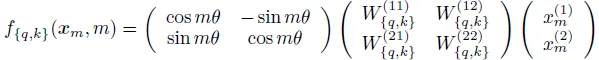

### General Form
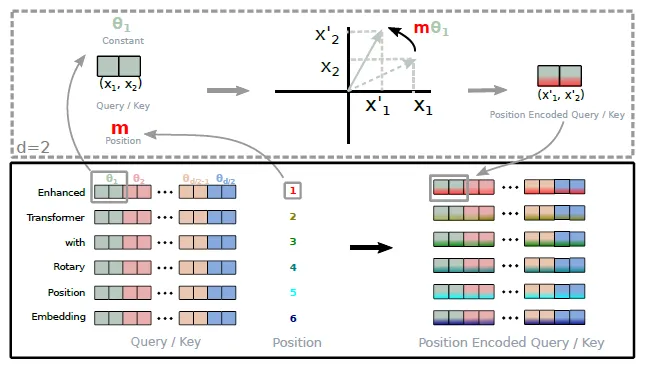

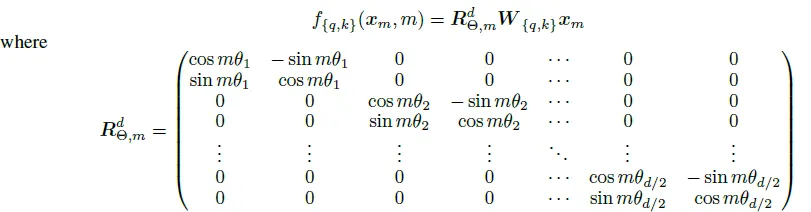


image.png

When applying RoPE to self-attention, qTmkn becomes:
image.png

with image.png

## 3. Implement the above position encoding methods

In [1]:
!pip install einops
!pip install torch==1.8.1
!pip install pytorch_lightning==1.4.9


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 562.7 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.1/804.1 MB 1.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.8.1 which is incompatible.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.8.1 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.8.1 which is incompatible.
Looking in ind

In [2]:
!pip install transformers==4.6.1
!pip install performer_pytorch==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 51.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 80.6 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=408b7e27b8458d0b2c90453717ccba098a402f05fa56ba808e2bfa05e0913d81
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for axial-positional-embedding: filename=axial_positional_embedding-0.2.1-py3-none-any.whl size=2901 sha256=348f05111cb0b38d43a3a7167c7a7e1370ba0f3b2b15cfb0ea6aec1f01b9

# Basic Position Encoding Modules

In [ ]:
import torch
import torch.nn as nn
from einops import rearrange, repeat

class LearnableAbsolutePositionEmbedding(nn.Module):
    def __init__(self, max_position_embeddings, hidden_size):
        super().__init__()
        self.is_absolute = True
        self.embeddings = nn.Embedding(max_position_embeddings, hidden_size)
        self.register_buffer('position_ids', torch.arange(max_position_embeddings))

    def forward(self, x):
        """
        return (b l d) / (b h l d)
        """
        position_ids = self.position_ids[:x.size(-2)]

        if x.dim() == 3:
            return x + self.embeddings(position_ids)[None, :, :]

        elif x.dim() == 4:
            h = x.size(1)
            x = rearrange(x, 'b h l d -> b l (h d)')
            x = x + self.embeddings(position_ids)[None, :, :]
            x = rearrange(x, 'b l (h d) -> b h l d', h=h)
            return x

In [ ]:
class FixedAbsolutePositionEmbedding(nn.Module):
    def __init__(self, max_position_embeddings, hidden_size, position_embedding_type):
        super().__init__()

        self.position_embedding_type = position_embedding_type
        self.is_absolute = True

        inv_freq = 1. / (10000 ** (torch.arange(0, hidden_size, 2, dtype=torch.float) / hidden_size))
        position = torch.arange(max_position_embeddings, dtype=torch.float)
        sinusoid_inp = torch.einsum('i,j -> ij', position, inv_freq)
        embeddings = torch.cat((sinusoid_inp.sin(), sinusoid_inp.cos()), dim=-1)
        self.register_buffer('embeddings', embeddings)

    def forward_fixed(self, x):
        """
        return (b l d)
        """
        return x + self.embeddings[None, :x.size(1), :]

    def forward_rope(self, x):
        """
        return (b l d)
        """
        embeddings = self.embeddings[None, :x.size(1), :] # b l d
        embeddings = rearrange(embeddings, 'b l (j d) -> b l j d', j=2)
        sin, cos = embeddings.unbind(dim=-2) # b l d//2
        sin, cos = map(lambda t: repeat(t, '... d -> ... (d 2)'), (sin, cos)) # b l d
        return x * cos + self.rotate_every_two(x) * sin

    @staticmethod
    def rotate_every_two(x):
        x = rearrange(x, '... (d j) -> ... d j', j=2)
        x1, x2 = x.unbind(dim=-1)
        x = torch.stack((-x2, x1), dim=-1)
        return rearrange(x, '... d j -> ... (d j)')

    def _forward(self, x):
        if self.position_embedding_type == 'fixed':
            return self.forward_fixed(x)

        elif self.position_embedding_type == 'rope':
            return self.forward_rope(x)

    def forward(self, x):
        if x.dim() == 3:
            return self._forward(x)

        elif x.dim() == 4:
            h = x.size(1)
            x = rearrange(x, 'b h l d -> (b h) l d')
            x = self._forward(x)
            x = rearrange(x, '(b h) l d -> b h l d', h=h)
            return x

In [ ]:
import math

class RelativePositionEmbedding(nn.Module):
    def __init__(self, 
                 relative_attention_num_buckets, num_attention_heads, 
                 hidden_size, position_embedding_type):

        super().__init__()

        self.relative_attention_num_buckets = relative_attention_num_buckets
        self.position_embedding_type = position_embedding_type
        self.num_attention_heads = num_attention_heads
        self.is_absolute = False

        if position_embedding_type == 'bias':
            self.embeddings = nn.Embedding(relative_attention_num_buckets, num_attention_heads)

        elif position_embedding_type == 'contextual(1)':
            self.embeddings = nn.Embedding(relative_attention_num_buckets, hidden_size)
            self.to_r = nn.Linear(hidden_size, hidden_size, bias=False)

        elif position_embedding_type == 'contextual(2)':
            self.embeddings = nn.Embedding(relative_attention_num_buckets, hidden_size)

    def compute_bias(self, q, k, to_q=None, to_k=None):
        """
        q, k: [b h l d]
        return [b h l l]
        """
        h = self.num_attention_heads
        query_position = torch.arange(q.size(2), dtype=torch.long, device=self.embeddings.weight.device)[:, None]
        key_position   = torch.arange(k.size(2), dtype=torch.long, device=self.embeddings.weight.device)[None, :]

        relative_position = query_position - key_position
        relative_position_bucket = self._relative_position_bucket(
            relative_position,
            num_buckets=self.relative_attention_num_buckets
        )

        if self.position_embedding_type == 'bias':
            bias = self.embeddings(relative_position_bucket)
            bias = rearrange(bias, 'm n h -> 1 h m n')

        elif self.position_embedding_type == 'contextual(1)':
            r = self.embeddings(relative_position_bucket)
            r = self.to_r(r)
            r = rearrange(r, 'm n (h d) -> h m n d', h=h)

            bias = torch.einsum('b h m d, h m n d -> b h m n', q, r)

        elif self.position_embedding_type == 'contextual(2)':
            r = self.embeddings(relative_position_bucket)

            kr = to_k(r)
            qr = to_q(r)

            kr = rearrange(kr, 'm n (h d) -> h m n d', h=h)
            qr = rearrange(qr, 'm n (h d) -> h m n d', h=h)

            bias1 = torch.einsum('b h m d, h m n d -> b h m n', q, kr)
            bias2 = torch.einsum('b h n d, h m n d -> b h m n', k, qr)

            bias = bias1 + bias2

        return bias

    @staticmethod
    def _relative_position_bucket(relative_position, num_buckets, max_distance=128):
        """
        relative_position: [m n]
        """

        num_buckets //= 2
        relative_buckets = (relative_position > 0).to(torch.long) * num_buckets
        relative_position = torch.abs(relative_position)

        max_exact = num_buckets // 2
        is_small = relative_position < max_exact

        relative_position_if_large = max_exact + (
            torch.log(relative_position.float() / max_exact)
            / math.log(max_distance / max_exact)
            * (num_buckets - max_exact)
        ).to(torch.long)

        relative_position_if_large = torch.min(
            relative_position_if_large, torch.full_like(relative_position_if_large, num_buckets - 1)
        )

        relative_buckets += torch.where(is_small, relative_position, relative_position_if_large)
        return relative_buckets

# Practice

Utilize the above codes to train a BERT model with different position encodings and see the quality of final token embedding.